# Zurich Case - auto insurance

Commercial auto insurance is a business insurance policy that applies to autos owned by or used in your business that protects your business against liability for damages caused by accidents involving your business autos and provides certain compensation to occupants of your business autos injured in accidents. The cost of this business is the insurance payoff and the revenue of this business is the annual premium.

* Three models were built for analysis (classification, regression, and clustering).
* There are four parts to build the classification, regression, and clustering model: load and data cleaning, data exploration and feature engineering, training the model/hyperparameter tuning and model evaluation, and predictive model building.
* The pattern differences between policy 2017 data and quote 2018 data was checked. They have the same pattern for each feature.

## Q1
The manager in charge of personal auto has asked you to help her: <br>
1.	target the potential customers in 2018 which will result in the lowest claim amounts. For example:<br>
a.	find customers with a low probability of having any claims <br>
b.	find customers with the lowest cost per claim, given that a claim occurs

## Q2
2.	create a marketing campaign that engages with potential 2018 customers based on their risk profiles (e.g.  letting riskier customers know about educational opportunities, which will benefit both the customer and insurance company by reducing the risk of claims).  <br>
In order to do that, the manager must make several risk profile ‘groups’ to be used in this campaign. 

## answer for Q1
* Binary classification model for finding customers with a low probability of having any claims <br>
The logistics regression model has <br>
	auc:0.706 <br>
	AccuracyScore:0.725 <br>
	Precision:0.825 <br>
	False Alarm Rate:0.323 <br>
The prediction result of has_claim of 2018 data was saved in data\external\auto_potential_customers_2018_claim.csv <br>
* Regression model for finding customers with the lowest cost per claim, given that a claim occurs <br>
The gamma regression didn't perform well (R2 is 0.24 and rmse is 0.833). So I tried the random forest regression (R2 is 0.48 and rmse is 0.69). <br>
The prediction result of the lowest cost per claim of 2018 data was saved in data\external\auto_potential_customers_2018_lowcost.csv <br>

## answer for Q2
* divide the customer into the different groups by the risk profile <br>

**Cluster 0**
* credit score is low, traffic env is relatively safe 
* multi claims and claim cost is not high

**Cluster 1**
* credit score is low, traffic env is relatively safe
* less claims and claim cost is very high

**Cluster 2**
* credit score is low, traffic env is relatively unsafe
* multi claims and claim cost is low

**Cluster 3**
* credit score is high, traffic env is safe
* no claim

The prediction result of the lowest cost per claim of 2018 data was saved in data\external\auto_potential_customers_2018_cluster.csv <br>

**metadata:** <br>
**2017 policy** <br>
**pol_number**, policy number for the insurance policy  <br>
**pol_eff_dt**,	auto insurance policy effective date  <br>
**gender**, gender of driver: F, M <br>
**agecat**, driver's age category: 1 (youngest), 2, 3, 4, 5, 6 <br>
**date_of_birth**, driver's date of birth <br>
**credit_score**, driver’s credit score(integer): 301-850, 301=excellent, 850=excellent <br>
**area**, driver's area of residence: A, B, C, D, E, F  <br>
**traffic_index**,	traffic index of driver’s area of residence(integer): 100=country average, >100 means worse traffic conditions than average <br>
**veh_age**, age of vehicle(categorical): 1 (youngest), 2, 3, 4  <br>
**veh_body**, vehicle body, coded as: BUS, CONVT = convertible, COUPE, HBACK = hatchback, HDTOP = hardtop, MCARA = motorized, caravan, MIBUS = minibus, PANVN = panel van, RDSTR = roadster, SEDAN, STNWG = station wagon, TRUCK, UTE = utility <br>
**veh_value**, vehicle value, in 10000s <br>
**claim_office**, office location of claim handling agent: A, B, C, D <br>
**numclaims**, number of claims(integer): 0 if no claim <br>
**claimcst0**, claim amount: 0 if no claim <br>
**annual_premium**,	total charged premium <br>

**2018 quote** <br>
**quote_number** <br>
**gender** <br>
**agecat** <br>
**date_of_birth** <br>
**credit_score** <br>
**area** <br>
**traffic_index** <br>
**veh_age** <br>
**veh_body** <br>
**veh_value**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## 1. Load
* Check the data type and missing value
* Check the pattern differences between the policy 2017 data and quote 2018 data
* Handling the missing value
* Handling the outlier
* Understand the profit of 2017 auto insurance

In [2]:
# load the data
po_2017_raw = pd.read_csv(r'data\raw\auto_policies_2017.csv')
qu_2018_raw = pd.read_csv(r'data\raw\auto_potential_customers_2018.csv')

* Check the data type and missing value

In [3]:
po_2017_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60392 entries, 0 to 60391
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pol_number      60392 non-null  int64  
 1   pol_eff_dt      60392 non-null  object 
 2   gender          60392 non-null  object 
 3   agecat          55561 non-null  float64
 4   date_of_birth   60392 non-null  object 
 5   credit_score    57591 non-null  float64
 6   area            60392 non-null  object 
 7   traffic_index   56889 non-null  float64
 8   veh_age         60392 non-null  int64  
 9   veh_body        60392 non-null  object 
 10  veh_value       60392 non-null  float64
 11  claim_office    10030 non-null  object 
 12  numclaims       60392 non-null  int64  
 13  claimcst0       60392 non-null  float64
 14  annual_premium  60392 non-null  float64
dtypes: float64(6), int64(3), object(6)
memory usage: 6.9+ MB


In [4]:
qu_2018_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7464 entries, 0 to 7463
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   quote_number   7464 non-null   int64  
 1   gender         7464 non-null   object 
 2   agecat         6832 non-null   float64
 3   date_of_birth  7464 non-null   object 
 4   credit_score   7109 non-null   float64
 5   area           7464 non-null   object 
 6   traffic_index  7015 non-null   float64
 7   veh_age        7464 non-null   int64  
 8   veh_body       7464 non-null   object 
 9   veh_value      7464 non-null   float64
dtypes: float64(4), int64(2), object(4)
memory usage: 583.2+ KB


In [5]:
po_2017_raw.head()

,pol_number,pol_eff_dt,gender,agecat,date_of_birth,credit_score,area,traffic_index,veh_age,veh_body,veh_value,claim_office,numclaims,claimcst0,annual_premium
0,64080188,7/10/2017,M,2.0,1/4/1989,631.0,B,140.9,4,TRUCK,0.924,NaN,0,0.000000,716.53
1,18917133,7/31/2017,M,2.0,6/21/1985,531.0,C,136.5,3,HBACK,1.430,B,1,583.010876,716.53
2,82742606,2/1/2017,M,6.0,7/25/1942,838.0,D,88.8,3,SEDAN,1.100,D,1,159.375757,716.53
3,43601997,10/17/2017,M,5.0,6/8/1959,835.0,E,NaN,2,SEDAN,2.090,NaN,0,0.000000,716.53
4,58746861,4/13/2017,F,4.0,5/16/1967,748.0,C,123.0,3,HBACK,0.803,C,1,143.555642,716.53


In [6]:
qu_2018_raw.head()

,quote_number,gender,agecat,date_of_birth,credit_score,area,traffic_index,veh_age,veh_body,veh_value
0,29323463,F,4.0,4/14/1968,750.0,C,124.5,2,HBACK,1.100
1,16732441,M,2.0,10/4/1984,567.0,F,NaN,3,STNWG,2.079
2,68744228,M,4.0,11/30/1962,378.0,D,111.4,3,HDTOP,2.354
3,30875047,F,3.0,5/17/1973,807.0,E,NaN,4,UTE,1.969
4,37049210,M,6.0,10/2/1945,844.0,C,111.0,1,HBACK,1.969


In [7]:
# check the missing value (agecat, credit_score, traffic_index, and claim_office has missing value)
print('train: \n', po_2017_raw.isnull().sum(),"\n")
print('test: \n', qu_2018_raw.isnull().sum())

train: 
 pol_number            0
pol_eff_dt            0
gender                0
agecat             4831
date_of_birth         0
credit_score       2801
area                  0
traffic_index      3503
veh_age               0
veh_body              0
veh_value             0
claim_office      50362
numclaims             0
claimcst0             0
annual_premium        0
dtype: int64 

test: 
 quote_number       0
gender             0
agecat           632
date_of_birth      0
credit_score     355
area               0
traffic_index    449
veh_age            0
veh_body           0
veh_value          0
dtype: int64


In [8]:
# check the value distributation in each feature 
for col in po_2017_raw.columns:
    print(po_2017_raw[col].value_counts())

64080188    1
94243229    1
99962332    1
40591400    1
56864789    1
           ..
11101678    1
35322736    1
20677001    1
44601724    1
94692371    1
Name: pol_number, Length: 60392, dtype: int64
1/29/2017    204
12/1/2017    201
8/27/2017    197
3/1/2017     196
6/5/2017     194
            ... 
7/13/2017    139
9/17/2017    139
1/15/2017    137
2/21/2017    137
9/28/2017    132
Name: pol_eff_dt, Length: 364, dtype: int64
F    34316
M    26076
Name: gender, dtype: int64
4.0    13279
3.0    12930
2.0    10497
5.0     8791
6.0     5379
1.0     4685
Name: agecat, dtype: int64
4/16/1985     14
4/15/1965     13
7/29/1977     13
12/12/1966    12
10/21/1963    12
              ..
9/26/1990      1
2/9/1966       1
2/13/1931      1
12/20/1925     1
9/2/1945       1
Name: date_of_birth, Length: 20844, dtype: int64
800.0    251
804.0    239
801.0    236
834.0    224
837.0    219
        ... 
475.0     28
340.0     27
407.0     25
409.0     24
440.0     24
Name: credit_score, Length: 550, dty

In [9]:
for col in qu_2018_raw.columns:
    print(qu_2018_raw[col].value_counts())

29323463    1
95368033    1
84531516    1
69343150    1
45246446    1
           ..
84146330    1
72294066    1
20471664    1
32211494    1
26967805    1
Name: quote_number, Length: 7464, dtype: int64
F    4287
M    3177
Name: gender, dtype: int64
4.0    1594
3.0    1559
2.0    1338
5.0    1115
6.0     636
1.0     590
Name: agecat, dtype: int64
10/30/1964    5
5/12/1960     4
6/24/1974     4
9/25/1952     4
10/31/1976    4
             ..
10/13/1932    1
11/1/1945     1
11/4/1986     1
4/30/1964     1
8/24/1940     1
Name: date_of_birth, Length: 6243, dtype: int64
807.0    35
821.0    34
832.0    33
601.0    32
630.0    32
         ..
482.0     1
451.0     1
434.0     1
486.0     1
358.0     1
Name: credit_score, Length: 548, dtype: int64
C    2304
A    1836
B    1433
D     849
E     636
F     406
Name: area, dtype: int64
144.0    136
145.5    130
148.5    127
142.5    116
141.0    105
        ... 
161.8      1
172.5      1
35.4       1
159.0      1
67.6       1
Name: traffic_index, Le

* Check the pattern differences between the policy 2017 data and quote 2018 data <br>
The reason why I want to do this is that I always want to make sure that the features/variables in the 
training and prediction set are draw from the same distribution. Only when that's true, I can apply whatever
machine learning algorithm on the data set. Otherwise, it would just make no sense to us to apply 
any analysis on the data

In [10]:
# divide categroical and continous groups
cat_v=['gender', 'agecat', 'area', 'veh_age', 'veh_body']
con_v=['credit_score', 'traffic_index', 'veh_value']

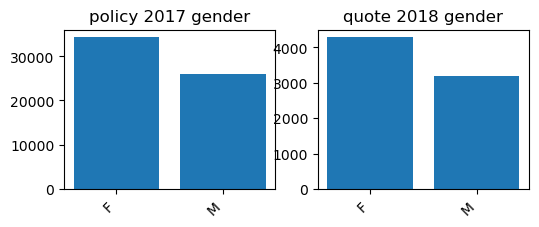

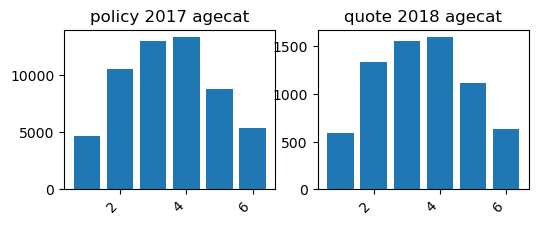

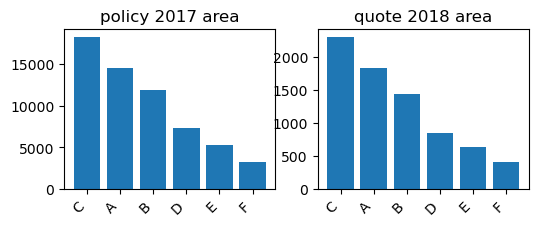

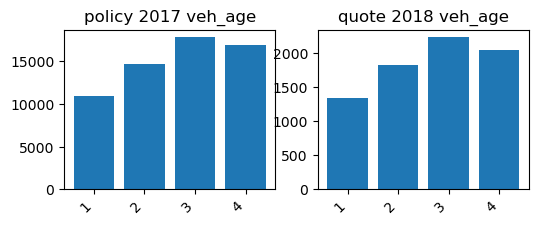

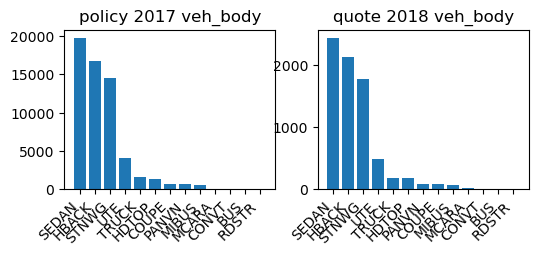

In [11]:
# visualize the distribution of the categorical columns 
count=1 # setup a counter to tell the index of the current plot

for i in range(len(cat_v)): # for each column in the categorical columns
    fig = plt.figure(figsize=(6,12)) # setup a "canvas" with size 6, 12
    
    plt.subplot(len(cat_v),2,count) # first plot the left one in the current row
    plt.bar(po_2017_raw.loc[po_2017_raw[cat_v[i]].notnull(),cat_v[i]].value_counts().index, po_2017_raw.loc[po_2017_raw[cat_v[i]].notnull(),cat_v[i]].value_counts().values) 
    plt.xticks(rotation = 45, ha='right')
    plt.title("policy 2017 "+cat_v[i]) 
    
    plt.subplot(len(cat_v),2,count+1) # second plot the right one in the current row
    plt.bar(qu_2018_raw.loc[qu_2018_raw[cat_v[i]].notnull(),cat_v[i]].value_counts().index, qu_2018_raw.loc[qu_2018_raw[cat_v[i]].notnull(),cat_v[i]].value_counts().values) 
    plt.xticks(rotation = 45, ha='right')
    plt.title("quote 2018 "+cat_v[i]) 
    count+=2 # plus two to the counter variable letting it know that I've already plottd two

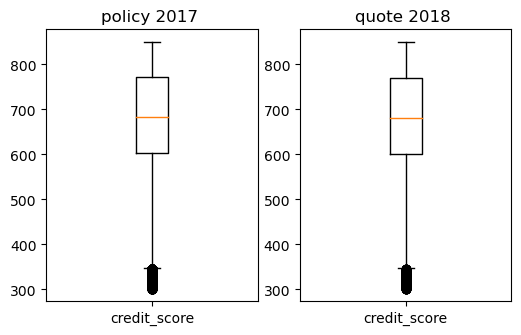

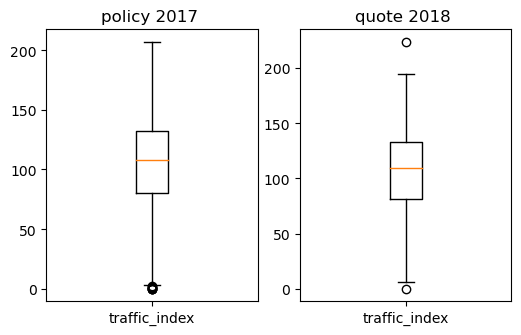

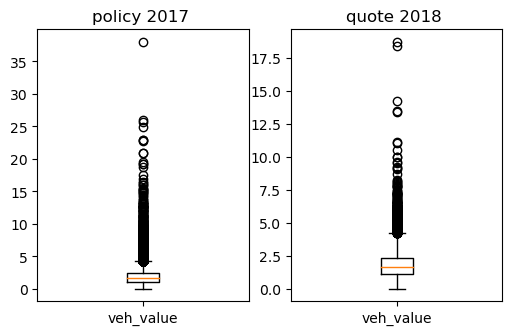

In [12]:
# visualized the continuous variables, similar with the code above
count=1
for i in range(len(con_v)):
    fig = plt.figure(figsize=(6,12))
    plt.subplot(len(con_v),2,count)
    plt.boxplot(po_2017_raw.loc[po_2017_raw[con_v[i]].notnull(),con_v[i]]) 
    plt.xticks([1],[con_v[i]])
    plt.title("policy 2017 ")
    
    plt.subplot(len(con_v),2,count+1)
    plt.boxplot(qu_2018_raw.loc[qu_2018_raw[con_v[i]].notnull(),con_v[i]])
    plt.xticks([1],[con_v[i]])
    plt.title("quote 2018 ")
    count+=2

#### after checking the pattern differences between the policy 2017 data and quote 2018 data, I found the variables have the same distribution, then I can start to do our analysis. 

In [13]:
po_2017=po_2017_raw.copy()
qu_2018=qu_2018_raw.copy()

* handling the missing value <br>
There are four ways to handle missing values: <br>
1. use mean or median for continuous data, mode for categorical data <br>
2. use nearest neighbor or other algorithms to predict the missing value based on the neighbor record <br>
3. find a relevant feature to the feature that has missing value, then based on the correlations, predict the missing value <br>
4. drop off

In [14]:
#handle missing value in agecat, I used the third method 
po_2017['age']=2017-po_2017['date_of_birth'].str[-4:].astype(int)
qu_2018['age']=2018-qu_2018['date_of_birth'].str[-4:].astype(int)

In [15]:
#find the range of each categore in agecat
maxage=po_2017.groupby(by='agecat').agg('age').max()
minage=po_2017.groupby(by='agecat').agg('age').min()
print(maxage)
print(minage)

agecat
1.0    27
2.0    37
3.0    47
4.0    57
5.0    67
6.0    94
Name: age, dtype: int32
agecat
1.0    18
2.0    28
3.0    38
4.0    48
5.0    58
6.0    68
Name: age, dtype: int32


In [16]:
#use a function to do the missing value imputation for agecat
def age_null(data):
    for i in range(len(data)):
        if pd.isnull(data.agecat.iloc[i]):
            if data.age.iloc[i]>=18 and data.age.iloc[i]<=27:
                data.agecat.iloc[i]=1.0
            elif data.age.iloc[i]>=28 and data.age.iloc[i]<=37:
                data.agecat.iloc[i]=2.0
            elif data.age.iloc[i]>=38 and data.age.iloc[i]<=47:
                data.agecat.iloc[i]=3.0
            elif data.age.iloc[i]>=48 and data.age.iloc[i]<=57:
                data.agecat.iloc[i]=4.0
            elif data.age.iloc[i]>=58 and data.age.iloc[i]<=67:
                data.agecat.iloc[i]=5.0
            elif data.age.iloc[i]>=68:
                data.agecat.iloc[i]=6.0
age_null(po_2017)
age_null(qu_2018)

In [17]:
#handle missing value in traffic_index, I used the first method
meantra=po_2017.groupby(by='area').agg('traffic_index').mean()
mediantra=po_2017.groupby(by='area').agg('traffic_index').median()
print(meantra)
print(mediantra)

area
A     80.201316
B    120.211648
C    128.474092
D     99.400110
E     45.018979
F    115.208244
Name: traffic_index, dtype: float64
area
A     80.1
B    120.1
C    133.5
D     99.5
E     43.5
F    116.0
Name: traffic_index, dtype: float64


In [18]:
#use a function to do the missing value imputation for traffic_index
def tra_null(data):
    for i in range(len(data)):
        if pd.isnull(data.traffic_index.iloc[i]):
            if data.area.iloc[i]=='A':
                data.traffic_index.iloc[i]=80.1
            elif data.area.iloc[i]=='B':
                data.traffic_index.iloc[i]=120.1
            elif data.area.iloc[i]=='C':
                data.traffic_index.iloc[i]=133.5
            elif data.area.iloc[i]=='D':
                data.traffic_index.iloc[i]=99.5
            elif data.area.iloc[i]=='E':
                data.traffic_index.iloc[i]=43.5
            elif data.area.iloc[i]=='F':
                data.traffic_index.iloc[i]=116.0
tra_null(po_2017)
tra_null(qu_2018)

In [19]:
#drop off the missing value of credit score since the percentage of missing value in this feature is low 
po_2017.dropna(subset=['credit_score'],inplace=True)
qu_2018.dropna(subset=['credit_score'],inplace=True)

#### missing value
for the missing value in agecat, use age to predict the missing value <br>
for the missing value in traffic_index, use mean of each category <br>
for the missing value in credit score, drop those off <br>

Text(0, 0.5, 'Count')

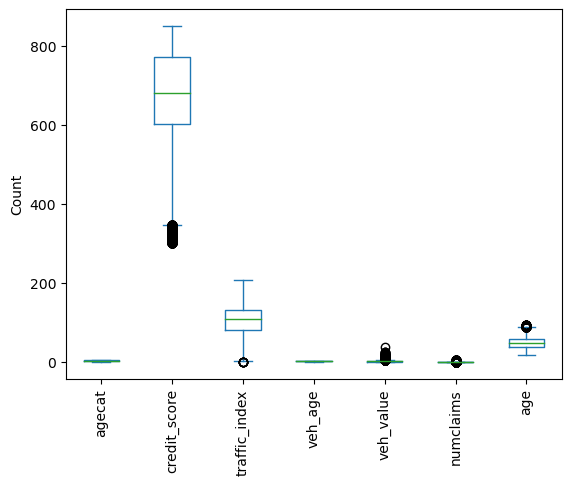

In [20]:
#outlier
po_2017[['agecat', 'credit_score', 'traffic_index', 'veh_age', 'veh_value', 'numclaims', 'age']].plot(kind="box")
plt.xticks(rotation=90)
plt.ylabel("Count")

#### no obvious outlier found

* I want to understand the profit of the auto insurance in 2017

In [21]:
rev=np.sum(po_2017['annual_premium'])
cost=np.sum(po_2017['numclaims']*po_2017['claimcst0'])
profit=rev-cost
print('profit: ', profit)

profit:  -16609459.274702199


#### the profit is -16M.

## 2. target the potential customers in 2018
- find customers with a low probability of having any claims

In [22]:
po_2017.columns

Index(['pol_number', 'pol_eff_dt', 'gender', 'agecat', 'date_of_birth',
       'credit_score', 'area', 'traffic_index', 'veh_age', 'veh_body',
       'veh_value', 'claim_office', 'numclaims', 'claimcst0', 'annual_premium',
       'age'],
      dtype='object')

In [23]:
po_claim=po_2017.copy()

#### feature engineering
* add have_claim feature to show if a customer have filed a claim as 1, no claim as 0

In [24]:
po_claim['have_claim']=np.where(po_claim['numclaims']!=0,1,0)

#### data exploration
* Check the contriubtion of features in training data to the difference classes in have_claim <br>
The useful feature should show a different contribution to the difference classes in have_claim

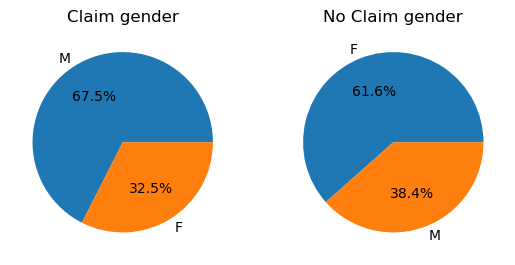

In [25]:
#divide data into claim vs non-claim groups
Cm=po_claim.loc[po_claim['have_claim']==1,:]
NCm=po_claim.loc[po_claim['have_claim']!=1,:]
#pie plot to show the feature pattern of non-default and default 
def pie(Cm,NCm,name):
    fig, axs = plt.subplots(1,2)
    axs[0].pie(Cm.loc[:,name].value_counts(),labels=Cm.loc[:,name].value_counts().index.tolist(), autopct='%1.1f%%')
    axs[0].set_title('Claim '+name)
    axs[1].pie(NCm.loc[:,name].value_counts(),labels=NCm.loc[:,name].value_counts().index.tolist(), autopct='%1.1f%%')
    axs[1].set_title('No Claim '+name)
pie(Cm,NCm,'gender')

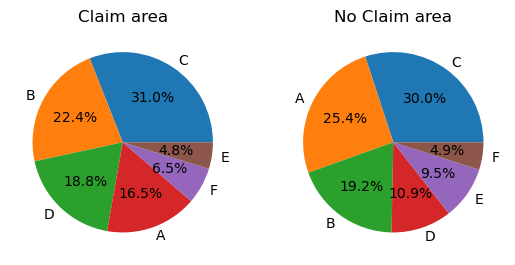

In [26]:
pie(Cm,NCm,'area')

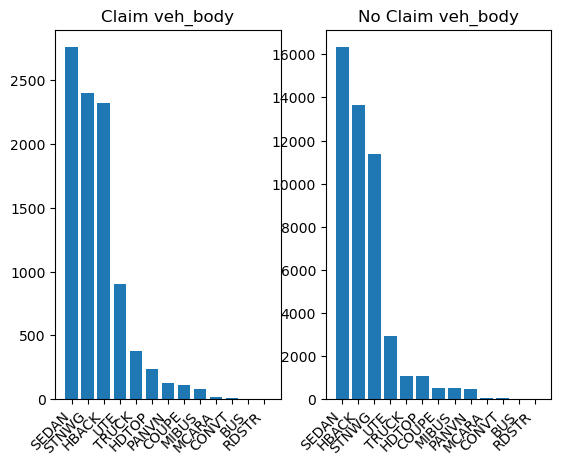

In [27]:
def bar(Cm,NCm,name):
    fig, axs = plt.subplots(1,2)
    axs[0].bar(Cm.loc[:,name].value_counts().index, Cm.loc[:,name].value_counts().values)
    axs[0].set_title('Claim '+name)
    axs[0].set_xticklabels(Cm.loc[:,name].value_counts().index,rotation = 45,ha='right')
    axs[1].bar(NCm.loc[:,name].value_counts().index, NCm.loc[:,name].value_counts().values)
    axs[1].set_title('No Claim '+name)
    axs[1].set_xticklabels(NCm.loc[:,name].value_counts().index,rotation = 45,ha='right')
bar(Cm,NCm,'veh_body')

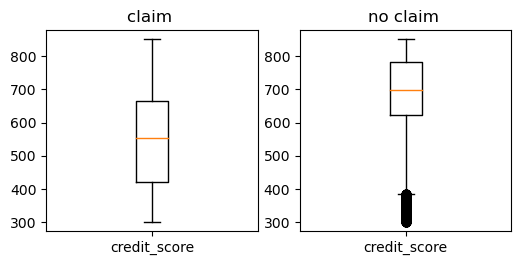

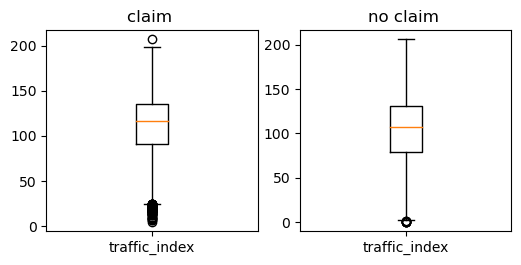

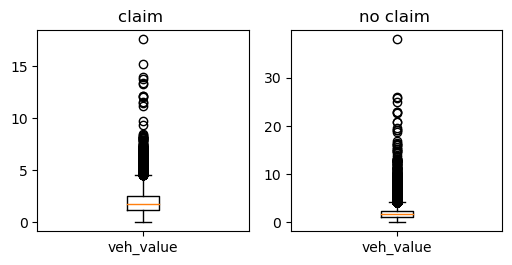

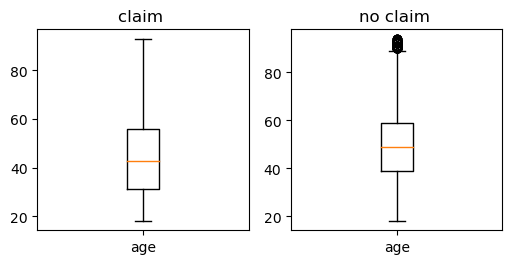

In [28]:
num_v=['credit_score', 'traffic_index', 'veh_value', 'age']
count=1
for i in range(len(num_v)):
    fig = plt.figure(figsize=(6,12))
    plt.subplot(len(num_v),2,count)
    plt.boxplot(po_claim.loc[po_claim['have_claim']==1,num_v[i]]) 
    #plt.ylim(np.percentile(po_2017[con_v[i]], 0.5), np.percentile(po_2017[con_v[i]], 99.5))
    plt.xticks([1],[num_v[i]])
    plt.title("claim ")
    
    plt.subplot(len(num_v),2,count+1)
    plt.boxplot(po_claim.loc[po_claim['have_claim']==0,num_v[i]]) 
    #plt.ylim(np.percentile(po_2017[con_v[i]], 0.5), np.percentile(po_2017[con_v[i]], 99.5))
    plt.xticks([1],[num_v[i]])
    plt.title("no claim ")
    count+=2

#### I found the feature of 'credit_score', 'traffic_index', 'veh_value', 'age', 'agecat', 'area', 'veh_age' are related to have_claim

In [29]:
po_claim.drop(['pol_number', 'pol_eff_dt', 'gender', 'date_of_birth',
               'claim_office', 'numclaims', 'claimcst0', 'annual_premium'],axis=1,inplace=True)
po_claim.drop(['area','veh_body'],axis=1,inplace=True)

* Check the pattern of the label <br>
I want to know if the label set is balanced or not. If it is imbalance, I would like to address the issue and adjust our model accordingly

Tips to deal with imbalanced data
1. Choose a good metrics:  <br/> Confusion Matrix: precision/Recall/F1-score
2. Resampling Your Dataset:
  * You can add copies of instances from the under-represented class called over-sampling
  * You can delete instances from the over-represented class, called under-sampling
  * imbalanced-learn package: https://github.com/scikit-learn-contrib/imbalanced-learn
3. Tune the class weight parameter

In [30]:
po_claim['have_claim'].value_counts(normalize=True)

0    0.837718
1    0.162282
Name: have_claim, dtype: float64

* Check if there is a correlation between each feature <br>
If yes, I will choose the feature has more variance

In [31]:
dep=['credit_score', 'traffic_index', 'veh_age', 'veh_value', 'age', 'agecat']

<AxesSubplot:>

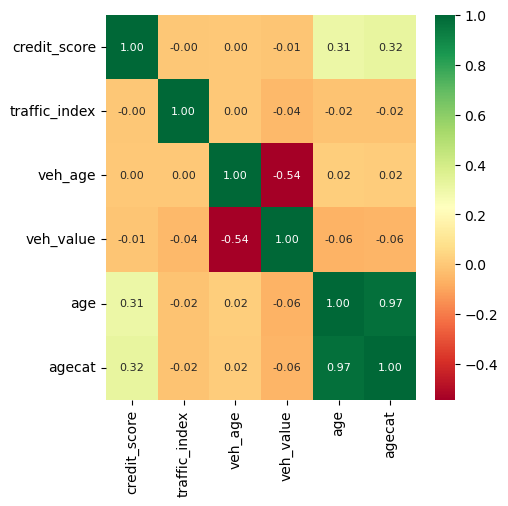

In [32]:
#correlation
plt.figure(figsize = (5,5))
sns.heatmap(po_claim[dep].corr(), 
            cmap = "RdYlGn", annot = True, annot_kws={"fontsize":8}, fmt=".2f")

In [33]:
po_claim.drop(['agecat'],axis=1,inplace=True)

In [34]:
#scaling numerical data
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
dep=['credit_score', 'traffic_index', 'veh_age', 'veh_value', 'age']
std = StandardScaler()
po_claim[dep] = std.fit_transform(po_claim[dep])

In [35]:
po_claim

,credit_score,traffic_index,veh_age,veh_value,age,have_claim
0,-0.228607,1.105409,1.241771,-0.774487,-1.347506,0
1,-0.961482,0.974337,0.305982,-0.394295,-1.084085,1
2,1.288443,-0.446613,0.305982,-0.642247,1.747696,1
3,1.266457,-1.796068,-0.629806,0.101607,0.628155,0
4,0.628856,0.572181,0.305982,-0.865403,0.101312,1
...,...,...,...,...,...,...
60387,1.046595,0.485792,0.305982,-0.179404,0.628155,0
60388,-0.382511,-1.796068,-0.629806,1.266978,-1.149940,0
60389,-0.968810,0.307056,0.305982,1.019027,-0.557242,0
60390,-2.200040,0.170026,0.305982,-0.162874,-0.425531,0


#### training model and evaluation

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.model_selection import GridSearchCV

In [37]:
#splitting train and test data 
Y = po_claim['have_claim'] # give the target variable another name
X = po_claim.drop('have_claim', axis= 1) # drop the target variable and id to make the data ready for training
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=1234) # split the training data with the test proportion set to 0.2

In [38]:
from imblearn.over_sampling import RandomOverSampler

#oversampling minority class using random sampling
ROS = RandomOverSampler(random_state = 11) 
os_rs_X, os_rs_Y = ROS.fit_resample(x_train,y_train)
os_rs_X = pd.DataFrame(data = os_rs_X,columns=dep)
os_rs_Y = pd.DataFrame(data = os_rs_Y,columns=['have_claim'])

In [39]:
from imblearn.under_sampling import RandomUnderSampler

#undersampling majority class using random sampling
RUS = RandomUnderSampler(random_state = 11)
us_rs_X,us_rs_Y = RUS.fit_resample(x_train,y_train)
us_rs_X = pd.DataFrame(data = us_rs_X,columns=dep)
us_rs_Y = pd.DataFrame(data = us_rs_Y,columns=['have_claim'])

In [40]:
#three datasets: org data, random oversample, random undersample
data = [[x_train,y_train],
        [os_rs_X, os_rs_Y],
        [us_rs_X, us_rs_Y]]

In [41]:
def evl(model,data):
    for features, labels in data:
        model.fit(features, labels)
        predict_test = model.predict(x_test)
        probabilities_test = RFC.predict_proba(x_test) 
        cm=confusion_matrix(y_test,predict_test)
        print('auc:%.3f' %roc_auc_score(y_test, predict_test))
        print("AccuracyScore:%.3f" %accuracy_score(y_test,predict_test))
        print("Precision:%.3f" %precision_score(y_test,predict_test,average='weighted'))
        print("False Alarm Rate:%.3f" %(cm[1][0]/(cm[1][0]+cm[1][1])))

In [42]:
#random forest with three datasets
RFC=RandomForestClassifier(n_estimators=100,class_weight='balanced',n_jobs=-1,random_state=1234)
evl(RFC,data)

auc:0.568
AccuracyScore:0.839
Precision:0.801
False Alarm Rate:0.833
auc:0.622
AccuracyScore:0.829
Precision:0.808
False Alarm Rate:0.684
auc:0.692
AccuracyScore:0.714
Precision:0.819
False Alarm Rate:0.341


In [43]:
#logistic regression with three datasets
logit  = LogisticRegression(C=1.0, class_weight='balanced', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=1234, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
evl(logit,data)

auc:0.706
AccuracyScore:0.728
Precision:0.825
False Alarm Rate:0.327
auc:0.707
AccuracyScore:0.729
Precision:0.826
False Alarm Rate:0.326
auc:0.706
AccuracyScore:0.725
Precision:0.825
False Alarm Rate:0.323


In [44]:
#final model with undersampling majority class using random sampling
logit  = LogisticRegression(C=1.0, class_weight='balanced', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=1234, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
logit.fit(us_rs_X, us_rs_Y)
predict_test = logit.predict(x_test) 
probabilities_test = logit.predict_proba(x_test) 
cm=confusion_matrix(y_test,predict_test)
print('auc:%.3f' %roc_auc_score(y_test, predict_test))
print("AccuracyScore:%.3f" %accuracy_score(y_test,predict_test))
print("Precision:%.3f" %precision_score(y_test,predict_test,average='weighted'))
print("False Alarm Rate:%.3f" %(cm[1][0]/(cm[1][0]+cm[1][1])))

auc:0.706
AccuracyScore:0.725
Precision:0.825
False Alarm Rate:0.323


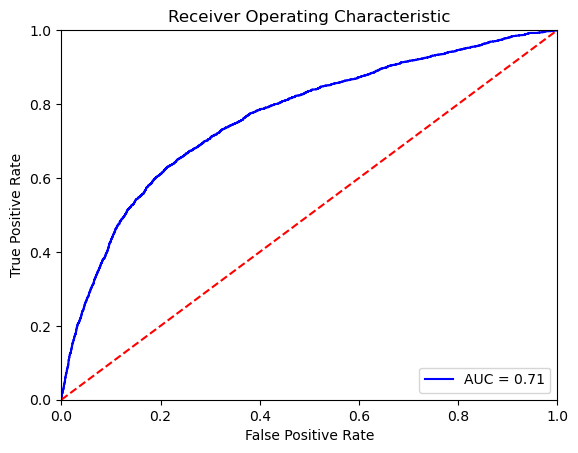

In [45]:
#model evaluation
fpr,tpr,thresholds = roc_curve(y_test,probabilities_test[:,1])
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_score(y_test, predict_test))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### predict the customer with a low probability of having any claim in 2018 quote

In [46]:
qu_2018.columns

Index(['quote_number', 'gender', 'agecat', 'date_of_birth', 'credit_score',
       'area', 'traffic_index', 'veh_age', 'veh_body', 'veh_value', 'age'],
      dtype='object')

In [47]:
qu_claim=qu_2018.drop(['quote_number', 'gender', 'agecat', 'date_of_birth','area','veh_body'],axis=1)

In [48]:
dep=['credit_score', 'traffic_index', 'veh_age', 'veh_value', 'age']
std = StandardScaler()
qu_claim[dep] = std.fit_transform(qu_claim[dep])

In [49]:
qu_claim

,credit_score,traffic_index,veh_age,veh_value,age
0,0.655131,0.595163,-0.635461,-0.651040,0.039559
1,-0.696825,0.343511,0.305095,0.110066,-1.007351
2,-2.093109,0.207322,0.305095,0.323860,0.432151
3,1.076233,-1.802937,1.245651,0.024548,-0.287600
4,1.349579,0.195480,-1.576017,0.024548,1.544493
...,...,...,...,...,...
7459,0.211867,-0.976925,1.245651,-0.685247,0.170423
7460,-0.763315,1.128074,-1.576017,2.008556,0.693878
7461,-0.992335,-1.234498,-1.576017,0.905379,0.170423
7462,1.150110,0.728391,1.245651,-0.881938,0.693878


In [50]:
predict_claim = logit.predict(qu_claim) 
probabilities_claim = logit.predict_proba(qu_claim)

In [51]:
#0=no claim, 1=claim
predict_claim

array([0, 1, 1, ..., 1, 0, 0])

In [52]:
#the prob of 0 and 1
probabilities_claim

array([[0.70605333, 0.29394667],
       [0.36130449, 0.63869551],
       [0.15288209, 0.84711791],
       ...,
       [0.46727044, 0.53272956],
       [0.75830236, 0.24169764],
       [0.52518821, 0.47481179]])

In [53]:
qu_2018['has_claim']=predict_claim
qu_2018['prob_noclaim']=probabilities_claim[:,0]
qu_2018['prob_claim']=probabilities_claim[:,1]

In [54]:
qu_2018.to_csv(r'data\external\auto_potential_customers_2018_claim.csv')

## 3. target the potential customers in 2018
- find customers with the lowest cost per claim, given that a claim occurs

In [55]:
#only select the records with having at least 1 claim
po_lowcost=po_2017.loc[po_claim['have_claim']==1,:]

In [56]:
po_lowcost.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9346 entries, 1 to 60383
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pol_number      9346 non-null   int64  
 1   pol_eff_dt      9346 non-null   object 
 2   gender          9346 non-null   object 
 3   agecat          9346 non-null   float64
 4   date_of_birth   9346 non-null   object 
 5   credit_score    9346 non-null   float64
 6   area            9346 non-null   object 
 7   traffic_index   9346 non-null   float64
 8   veh_age         9346 non-null   int64  
 9   veh_body        9346 non-null   object 
 10  veh_value       9346 non-null   float64
 11  claim_office    9346 non-null   object 
 12  numclaims       9346 non-null   int64  
 13  claimcst0       9346 non-null   float64
 14  annual_premium  9346 non-null   float64
 15  age             9346 non-null   int32  
dtypes: float64(6), int32(1), int64(3), object(6)
memory usage: 1.2+ MB


#### feature engineering
* add claim_total feature to show the total amount of all filed claims
* add claim_avg_veh_ratio feature to show the ratio of claimcst0 to veh_value

In [57]:
po_lowcost['claim_total']=po_lowcost['numclaims']*po_lowcost['claimcst0']

In [58]:
po_lowcost['claim_avg_veh_ratio']=po_lowcost['claimcst0']/(po_lowcost['veh_value']*10000)
po_lowcost['claim_avg_veh_ratio']=np.where(po_lowcost['claim_avg_veh_ratio']>10000000000,0,po_lowcost['claim_avg_veh_ratio'])

#### data exploration
* Check the distribution of claimcst0 and claim_avg_veh_ratio  <br>

Text(0.5, 0, 'Amount')

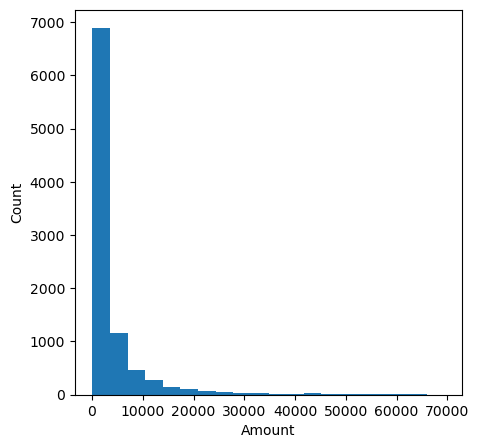

In [59]:
#distribution of amount
fig, axs = plt.subplots(figsize=(5, 5))
axs.hist(po_lowcost['claimcst0'],bins=20)
axs.set_ylabel('Count')
axs.set_xlabel('Amount')

Text(0.5, 0, 'Ratio')

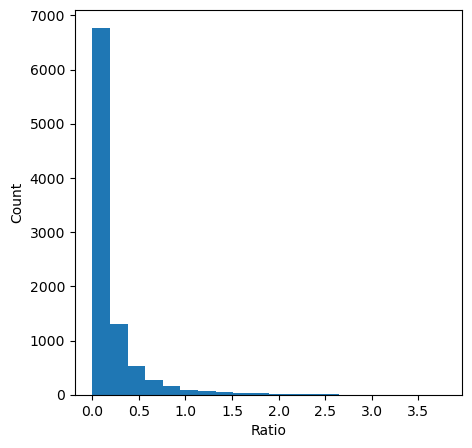

In [60]:
fig, axs = plt.subplots(figsize=(5, 5))
axs.hist(po_lowcost['claim_avg_veh_ratio'],bins=20)
axs.set_ylabel('Count')
axs.set_xlabel('Ratio')

In [67]:
po_lowcost[['claimcst0','claim_avg_veh_ratio','claim_total']].describe()

,claimcst0,claim_avg_veh_ratio,claim_total
count,9346.000000,9346.000000,9346.000000
mean,3906.226649,0.194533,6192.503585
std,7498.530634,0.318184,16702.312687
min,80.363865,0.000000,80.363865
25%,475.603976,0.031391,511.656204
50%,1333.867685,0.081930,1535.497099
75%,3773.782384,0.209765,4746.060613
max,69478.897830,3.783489,314218.741750


#### I may define the claim_avg_veh_ratio smaller than 0.081 as the group as the low cost group, which I can raise the premium. The claim_avg_veh_ratio between 0.081 to 0.209 is the middle cost group, which I need to consider the strategy. But the claim_avg_veh_ratio larger than 0.209 is the high cost group, which I can reject to provide the auto insurance. 

* Check the contriubtion of features in training data to the difference classes in claimcst0 <br>
The useful feature should show a different contribution to the difference classes in claimcst0

Text(0.5, 1.0, 'gender ')

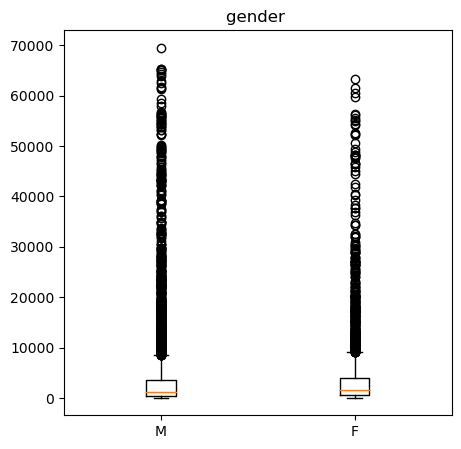

In [68]:
fig = plt.figure(figsize=(5,5))
plt.boxplot([po_lowcost.loc[po_lowcost['gender']=='M','claimcst0'],po_lowcost.loc[po_lowcost['gender']=='F','claimcst0']]) 
plt.xticks([1,2],['M','F'])
plt.title("gender ")

Text(0.5, 1.0, 'agecat ')

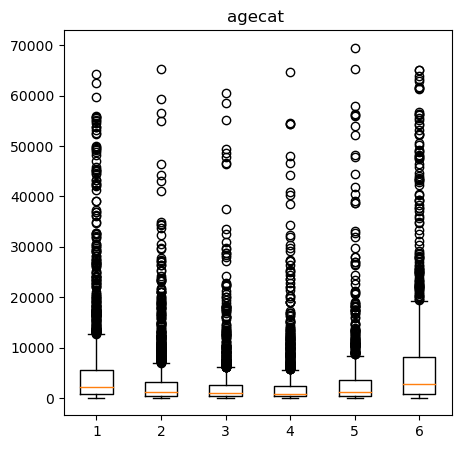

In [69]:
fig = plt.figure(figsize=(5,5))
plt.boxplot([po_lowcost.loc[po_lowcost['agecat']==1,'claimcst0'],po_lowcost.loc[po_lowcost['agecat']==2,'claimcst0'],
             po_lowcost.loc[po_lowcost['agecat']==3,'claimcst0'],po_lowcost.loc[po_lowcost['agecat']==4,'claimcst0'],
             po_lowcost.loc[po_lowcost['agecat']==5,'claimcst0'],po_lowcost.loc[po_lowcost['agecat']==6,'claimcst0']]) 
plt.title("agecat ")

Text(0.5, 1.0, 'area ')

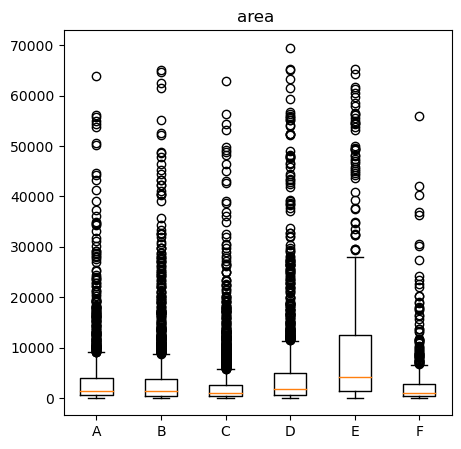

In [70]:
fig = plt.figure(figsize=(5,5))
plt.boxplot([po_lowcost.loc[po_lowcost['area']=='A','claimcst0'],po_lowcost.loc[po_lowcost['area']=='B','claimcst0'],
             po_lowcost.loc[po_lowcost['area']=='C','claimcst0'],po_lowcost.loc[po_lowcost['area']=='D','claimcst0'],
             po_lowcost.loc[po_lowcost['area']=='E','claimcst0'],po_lowcost.loc[po_lowcost['area']=='F','claimcst0']]) 
plt.xticks([1,2,3,4,5,6],['A','B','C','D','E','F'])
plt.title("area ")

Text(0.5, 1.0, 'veh_body ')

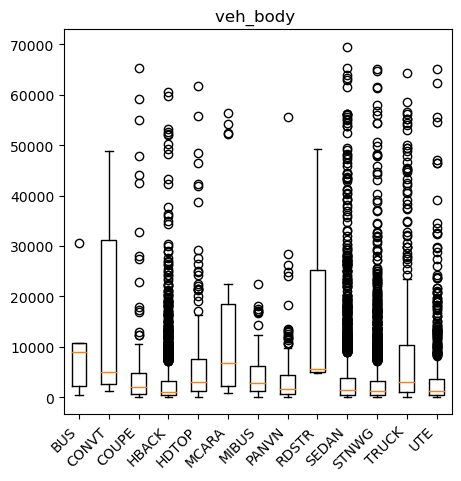

In [71]:
fig = plt.figure(figsize=(5,5))
plt.boxplot([po_lowcost.loc[po_lowcost['veh_body']=='BUS','claimcst0'],po_lowcost.loc[po_lowcost['veh_body']=='CONVT','claimcst0'],
             po_lowcost.loc[po_lowcost['veh_body']=='COUPE','claimcst0'],po_lowcost.loc[po_lowcost['veh_body']=='HBACK','claimcst0'],
             po_lowcost.loc[po_lowcost['veh_body']=='HDTOP','claimcst0'],po_lowcost.loc[po_lowcost['veh_body']=='MCARA','claimcst0'],
             po_lowcost.loc[po_lowcost['veh_body']=='MIBUS','claimcst0'],
             po_lowcost.loc[po_lowcost['veh_body']=='PANVN','claimcst0'],po_lowcost.loc[po_lowcost['veh_body']=='RDSTR','claimcst0'],
             po_lowcost.loc[po_lowcost['veh_body']=='SEDAN','claimcst0'],po_lowcost.loc[po_lowcost['veh_body']=='STNWG','claimcst0'],
             po_lowcost.loc[po_lowcost['veh_body']=='TRUCK','claimcst0'],po_lowcost.loc[po_lowcost['veh_body']=='UTE','claimcst0']]) 
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13],['BUS','CONVT','COUPE','HBACK','HDTOP','MCARA','MIBUS',
                                            'PANVN','RDSTR','SEDAN','STNWG','TRUCK','UTE'],rotation = 45, ha='right')
plt.title("veh_body ")

* For veh_body, it shows the various of claim_avg in different group.Since it is a categroical data, I divided the veh_type into two groups, the safe group has the model with low cost, the ohter has the higher cost. 

<AxesSubplot:>

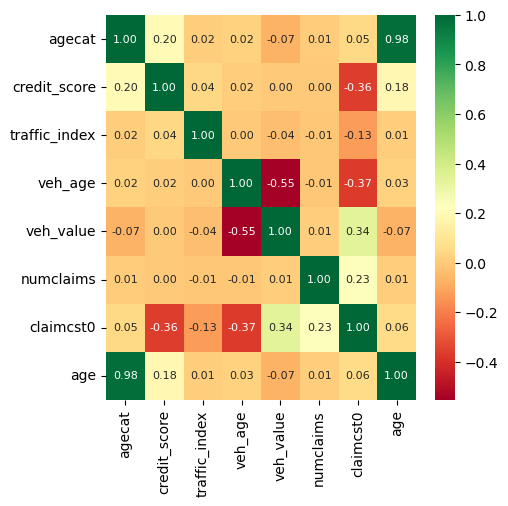

In [72]:
#correlation
dep=['agecat','credit_score','traffic_index','veh_age','veh_value','numclaims','claimcst0','age'] 
plt.figure(figsize = (5,5))
sns.heatmap(po_lowcost[dep].corr(), 
            cmap = "RdYlGn", annot = True, annot_kws={"fontsize":8}, fmt=".2f")

In [73]:
nosafe=['BUS','CONVT','HDTOP','MCARA','MIBUS','RDSTR','TRUCK']
po_lowcost['veh_safe']=1
po_lowcost.loc[po_lowcost['veh_body'].isin(nosafe),'veh_safe']=0
po_lowcost['veh_safe'].value_counts()

1    8610
0     736
Name: veh_safe, dtype: int64

In [74]:
po_lowcost.drop(['pol_number', 'pol_eff_dt', 'gender', 'date_of_birth',
                'claim_office', 'numclaims', 'annual_premium',
                'claim_total','claim_avg_veh_ratio'],axis=1,inplace=True)
po_lowcost.drop(['area','veh_body'],axis=1,inplace=True)
po_lowcost.drop(['agecat'],axis=1,inplace=True)

In [75]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
#convert binary
le = LabelEncoder()
for i in ['veh_safe']:
    po_lowcost[i] = le.fit_transform(po_lowcost[i])
#scaling the numerical data
dep=['credit_score', 'traffic_index', 'veh_age', 'veh_value', 'age']
std = StandardScaler()
po_lowcost[dep] = std.fit_transform(po_lowcost[dep])
scalery = StandardScaler().fit(po_lowcost[['claimcst0']])
po_lowcost[['claimcst0']]= scalery.transform(po_lowcost[['claimcst0']])+1

In [76]:
po_lowcost

,credit_score,traffic_index,veh_age,veh_value,claimcst0,age,veh_safe
1,-0.145710,0.821006,0.273535,-0.443328,0.556794,-0.722483,1
2,1.903636,-0.724193,0.273535,-0.695114,0.500295,1.775238,1
4,1.302851,0.383686,0.273535,-0.921721,0.498185,0.323074,1
9,-0.332621,0.289743,0.273535,-0.057256,0.617661,-0.664397,1
12,-0.859978,-0.873206,1.196779,-0.317435,1.157528,0.264988,0
...,...,...,...,...,...,...,...
60363,-0.239166,0.286504,0.273535,0.907923,0.789744,-0.373964,1
60374,-1.153695,1.112554,1.196779,-1.223864,0.651259,-1.361435,1
60380,-0.646365,0.811288,-0.649708,-0.342613,1.976226,2.530363,1
60381,-0.292569,0.626642,1.196779,-1.047614,0.519813,0.439248,1


#### training model and evluation

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import GammaRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt

In [78]:
#Independent Variables
x = po_lowcost.drop("claimcst0", axis = 1) 
#Depenedent Variables 
y = po_lowcost["claimcst0"]

In [79]:
#splitting train and test data 
x_train,x_test, y_train, y_test = train_test_split(x,y, test_size =0.25, random_state = 3)

In [80]:
#Applying Gamma Regression Model
lr_regressor =GammaRegressor()
lr_regressor.fit(x_train, y_train)

GammaRegressor()

In [81]:
y_pred = lr_regressor.predict(x_test)

In [82]:
#Accuracy of Model (Apply R2_score)
r2_score(y_test, y_pred)

0.25260502607642954

In [83]:
#Checking Root Mean Square error
rmse = sqrt(mean_squared_error(y_test,  y_pred))
rmse

0.8335529314742282

In [84]:
#Residue of the Linear Regression Model 
residue_lr = y_test -y_pred

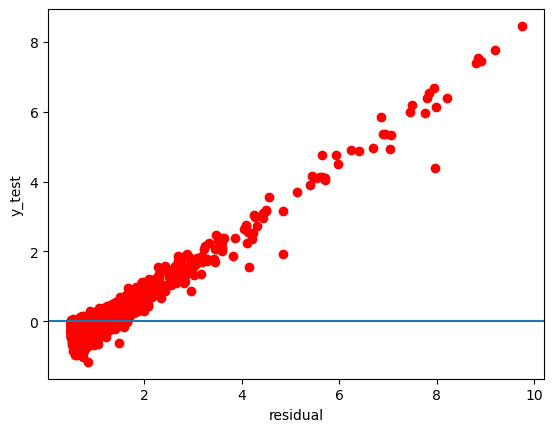

In [85]:
#Plotting Residual Plot
plt.scatter(y_test,residue_lr, c = "red")
plt.xlabel("residual")
plt.ylabel("y_test")
plt.axhline(y = 0)

In [86]:
#Applying Random Forest Regression Model
rf_regressor=RandomForestRegressor()
rf_regressor.fit(x_train, y_train)

RandomForestRegressor()

In [87]:
y_pred = rf_regressor.predict(x_test)

In [88]:
#Accuracy of Model (Apply R2_score)
r2_score(y_test, y_pred)

0.48659037294568763

In [89]:
#Checking Root Mean Square error
rmse = sqrt(mean_squared_error(y_test,  y_pred))
rmse

0.6908600833839265

In [90]:
#Residue of the Linear Regression Model 
residue_lr = y_test -y_pred

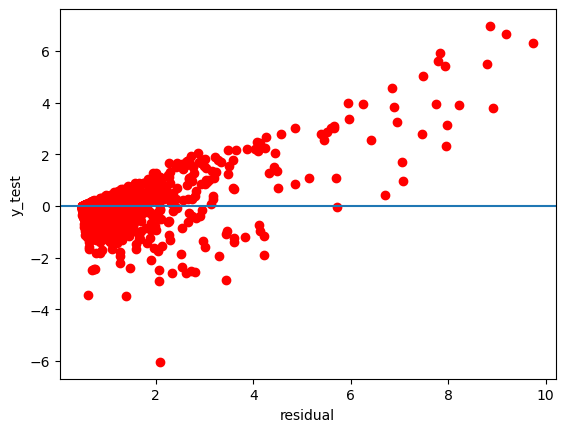

In [91]:
#Plotting Residual Plot
plt.scatter(y_test,residue_lr, c = "red")
plt.xlabel("residual")
plt.ylabel("y_test")
plt.axhline(y = 0)

#### predict the customer with the lowest cost per claim in 2018 quote

In [92]:
qu_2018.columns

Index(['quote_number', 'gender', 'agecat', 'date_of_birth', 'credit_score',
       'area', 'traffic_index', 'veh_age', 'veh_body', 'veh_value', 'age',
       'has_claim', 'prob_noclaim', 'prob_claim'],
      dtype='object')

In [93]:
qu_2018['has_claim']=predict_claim

In [94]:
qu_lowcost=qu_2018.loc[qu_2018['has_claim']==1,:]
qu_lowcost

,quote_number,gender,agecat,date_of_birth,credit_score,area,traffic_index,veh_age,veh_body,veh_value,age,has_claim,prob_noclaim,prob_claim
1,16732441,M,2.0,10/4/1984,567.0,F,116.0,3,STNWG,2.079,34,1,0.361304,0.638696
2,68744228,M,4.0,11/30/1962,378.0,D,111.4,3,HDTOP,2.354,56,1,0.152882,0.847118
6,58572612,M,5.0,3/27/1953,647.0,F,156.0,3,HDTOP,2.915,65,1,0.409736,0.590264
8,90845095,F,1.0,1/17/1999,601.0,B,105.2,2,HBACK,1.430,19,1,0.468599,0.531401
9,97453004,F,3.0,12/2/1979,672.0,C,145.5,2,STNWG,3.905,39,1,0.442732,0.557268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7453,73083647,F,3.0,8/11/1977,455.0,E,30.0,4,HBACK,0.451,41,1,0.407518,0.592482
7455,60593173,F,3.0,10/13/1979,427.0,A,67.6,3,STNWG,1.980,39,1,0.268520,0.731480
7457,69144152,F,3.0,11/2/1974,642.0,B,123.7,4,SEDAN,0.847,44,1,0.485006,0.514994
7460,73906733,M,5.0,5/25/1958,558.0,C,142.5,1,STNWG,4.521,60,1,0.305670,0.694330


In [95]:
nosafe=['BUS','CONVT','HDTOP','MCARA','MIBUS','RDSTR','TRUCK']
qu_lowcost['veh_safe']=1
qu_lowcost.loc[qu_lowcost['veh_body'].isin(nosafe),'veh_safe']=0

In [96]:
qu_lowcost.drop(['quote_number', 'gender', 'date_of_birth', 'agecat','area','veh_body','has_claim','prob_noclaim','prob_claim'],axis=1,inplace=True)

In [97]:
qu_lowcost

,credit_score,traffic_index,veh_age,veh_value,age,veh_safe
1,567.0,116.0,3,2.079,34,1
2,378.0,111.4,3,2.354,56,0
6,647.0,156.0,3,2.915,65,0
8,601.0,105.2,2,1.430,19,1
9,672.0,145.5,2,3.905,39,1
...,...,...,...,...,...,...
7453,455.0,30.0,4,0.451,41,1
7455,427.0,67.6,3,1.980,39,1
7457,642.0,123.7,4,0.847,44,1
7460,558.0,142.5,1,4.521,60,1


In [98]:
#convert binary
le = LabelEncoder()
for i in ['veh_safe']:
    qu_lowcost[i] = le.fit_transform(qu_lowcost[i])
#scaling the numerical data
dep=['credit_score', 'traffic_index', 'veh_age', 'veh_value', 'age']
std = StandardScaler()
qu_lowcost[dep] = std.fit_transform(qu_lowcost[dep])

In [99]:
predict_pred = rf_regressor.predict(qu_lowcost)

In [100]:
y_new_inverse = scalery.inverse_transform([predict_pred]-np.ones(predict_pred.shape))

In [101]:
predict_pred-np.ones(predict_pred.shape)

array([-0.43507074,  1.10588953, -0.15196023, ..., -0.47423252,
        0.61528276,  0.36143726])

In [102]:
y_new_inverse

array([[  644.00992252, 12198.32953333,  2766.80917268, ...,
          350.36982856,  8519.69647407,  6616.33004721]])

In [103]:
qu_2018['predicted_avg_claim_cost']=0
qu_2018.loc[qu_2018['has_claim']==1,'predicted_avg_claim_cost']=y_new_inverse.T

In [104]:
qu_2018.to_csv(r'data\external\auto_potential_customers_2018_lowcost.csv')

## 4. Divide the customer into different group by the risk profile

In [105]:
po_cluster=po_2017.copy()

In [106]:
po_cluster

,pol_number,pol_eff_dt,gender,agecat,date_of_birth,credit_score,area,traffic_index,veh_age,veh_body,veh_value,claim_office,numclaims,claimcst0,annual_premium,age
0,64080188,7/10/2017,M,2.0,1/4/1989,631.0,B,140.9,4,TRUCK,0.924,NaN,0,0.000000,716.53,28
1,18917133,7/31/2017,M,2.0,6/21/1985,531.0,C,136.5,3,HBACK,1.430,B,1,583.010876,716.53,32
2,82742606,2/1/2017,M,6.0,7/25/1942,838.0,D,88.8,3,SEDAN,1.100,D,1,159.375757,716.53,75
3,43601997,10/17/2017,M,5.0,6/8/1959,835.0,E,43.5,2,SEDAN,2.090,NaN,0,0.000000,716.53,58
4,58746861,4/13/2017,F,4.0,5/16/1967,748.0,C,123.0,3,HBACK,0.803,C,1,143.555642,716.53,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60387,15995672,3/11/2017,F,5.0,4/30/1959,805.0,B,120.1,3,SEDAN,1.716,NaN,0,0.000000,716.53,58
60388,91108898,12/15/2017,M,2.0,11/25/1986,610.0,E,43.5,2,UTE,3.641,NaN,0,0.000000,716.53,31
60389,71295464,1/31/2017,F,3.0,1/27/1977,530.0,B,114.1,3,STNWG,3.311,NaN,0,0.000000,716.53,40
60390,94120526,11/24/2017,F,3.0,4/22/1975,362.0,C,109.5,3,SEDAN,1.738,NaN,0,0.000000,716.53,42


#### feature engineering

In [107]:
po_cluster['has_claim']=np.where(po_cluster['numclaims']!=0,1,0)

In [108]:
po_cluster.drop(['pol_number', 'pol_eff_dt', 'date_of_birth', 'claim_office', 'annual_premium', 'agecat', 'area'],axis=1,inplace=True)

In [109]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
#convert binary
le = LabelEncoder()
for i in ['gender']:
    po_cluster[i] = le.fit_transform(po_cluster[i])
#scaling the numerical data
dep=['credit_score', 'traffic_index', 'veh_age', 'veh_value', 'age', 'numclaims', 'claimcst0']
std = StandardScaler()
po_cluster[dep] = std.fit_transform(po_cluster[dep])
#
nosafe=['BUS','CONVT','HDTOP','MCARA','MIBUS','RDSTR','TRUCK']
po_cluster['veh_safe']=1
po_cluster.loc[po_cluster['veh_body'].isin(nosafe),'veh_safe']=0
po_cluster.drop('veh_body',axis=1,inplace=True)

In [110]:
po_cluster.describe()

,gender,credit_score,traffic_index,veh_age,veh_value,numclaims,claimcst0,age,has_claim,veh_safe
count,57591.000000,5.759100e+04,5.759100e+04,5.759100e+04,5.759100e+04,5.759100e+04,5.759100e+04,5.759100e+04,57591.000000,57591.000000
mean,0.431647,3.925791e-16,4.431781e-16,-6.791347e-16,4.751500e-17,9.195992e-16,1.066973e-16,-1.812838e-16,0.162282,0.936570
std,0.495310,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,0.368713,0.243737
min,0.000000,-2.647093e+00,-3.091903e+00,-1.565594e+00,-1.468751e+00,-3.829964e-01,-1.894326e-01,-2.006060e+00,0.000000,0.000000
25%,0.000000,-4.411406e-01,-7.057799e-01,-6.298060e-01,-6.339817e-01,-3.829964e-01,-1.894326e-01,-7.548078e-01,0.000000,1.000000
50%,0.000000,1.451591e-01,1.640676e-01,3.059824e-01,-2.289946e-01,-3.829964e-01,-1.894326e-01,-3.039883e-02,0.000000,1.000000
75%,1.000000,8.047462e-01,8.402847e-01,1.241771e+00,3.082330e-01,-3.829964e-01,-1.894326e-01,6.281548e-01,0.000000,1.000000
max,1.000000,1.376388e+00,3.074482e+00,1.241771e+00,2.709523e+01,8.767828e+00,2.057304e+01,2.998948e+00,1.000000,1.000000


In [111]:
po_cluster_in=po_cluster.loc[po_cluster['has_claim']==1,:]
po_cluster_in.drop('has_claim',axis=1,inplace=True)

#### clustering model for policy 2017 (hyperparameter tunning for K) 

Text(0, 0.5, 'Inertia')

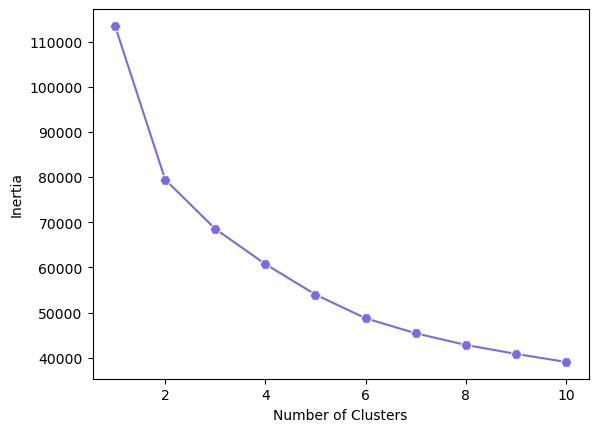

In [112]:
from sklearn.cluster import KMeans
kinertia=[]

for i in range(1,11):
    kmodel=KMeans(n_clusters=i)
    kmodel.fit(po_cluster_in)
    kinertia.append(kmodel.inertia_)

inertia_df=pd.DataFrame({"no_k":list(range(1,11)),"inertia":kinertia})

sns.lineplot(x=inertia_df["no_k"],y=inertia_df["inertia"],color="mediumslateblue",marker="H",markersize=8,markeredgecolor="w",legend=False)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")

Text(0, 0.5, 'Silhouette Score')

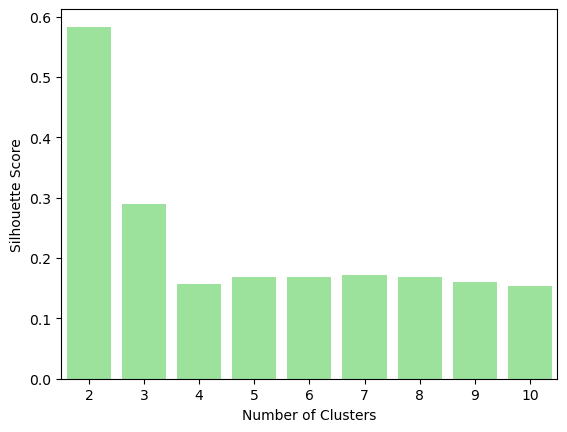

In [113]:
from sklearn.metrics import silhouette_score
ksilhouette=[]

for j in range(2,11):
    kmodel=KMeans(n_clusters=j)
    kpredict=kmodel.fit_predict(po_cluster_in)
    kscores=silhouette_score(po_cluster_in,kpredict)
    ksilhouette.append(kscores)

silhouette_df=pd.DataFrame({"no_k":list(range(2,11)),"silhoutte":ksilhouette})

sns.barplot(x=silhouette_df["no_k"],y=silhouette_df["silhoutte"],color="lightgreen")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")

#### I chose 3 as the number of clusters

In [114]:
model=KMeans(n_clusters=3)
model.fit(po_cluster_in)
labels=model.labels_

In [115]:
po_cluster["CLUSTER"]=3
po_cluster.loc[po_cluster['has_claim']==1,"CLUSTER"]=labels
po_cluster.head()

,gender,credit_score,traffic_index,veh_age,veh_value,numclaims,claimcst0,age,has_claim,veh_safe,CLUSTER
0,1,-0.228607,1.105409,1.241771,-0.774487,-0.382996,-0.189433,-1.347506,0,0,3
1,1,-0.961482,0.974337,0.305982,-0.394295,1.447168,-0.015211,-1.084085,1,1,1
2,1,1.288443,-0.446613,0.305982,-0.642247,1.447168,-0.141806,1.747696,1,1,1
3,1,1.266457,-1.796068,-0.629806,0.101607,-0.382996,-0.189433,0.628155,0,1,3
4,0,0.628856,0.572181,0.305982,-0.865403,1.447168,-0.146534,0.101312,1,1,1


In [116]:
cluster_df=po_cluster.groupby("CLUSTER").mean().T
cluster_df

CLUSTER,0,1,2,3
gender,0.659988,0.679131,0.668050,0.384434
credit_score,-1.561083,-0.591477,-1.909110,0.155268
traffic_index,0.036248,0.275502,-0.217458,-0.042492
veh_age,-0.747262,0.248380,-1.258842,-0.005566
veh_value,0.647522,-0.140869,1.410222,-0.008191
numclaims,2.686331,1.780442,3.026730,-0.382996
claimcst0,2.731840,0.218025,11.983870,-0.189433
age,-0.257536,-0.273898,-0.042969,0.051330
has_claim,1.000000,1.000000,1.000000,0.000000
veh_safe,0.889806,0.934665,0.730290,0.939538


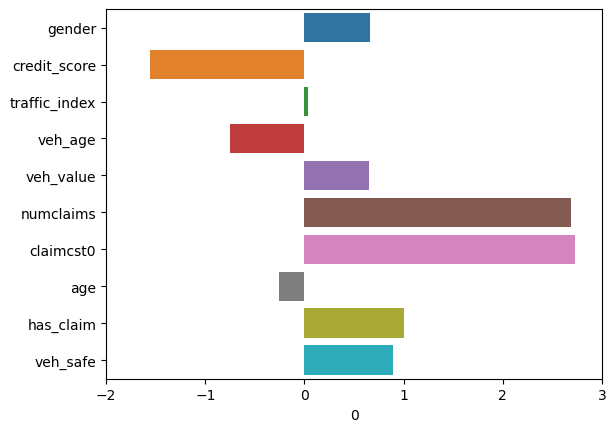

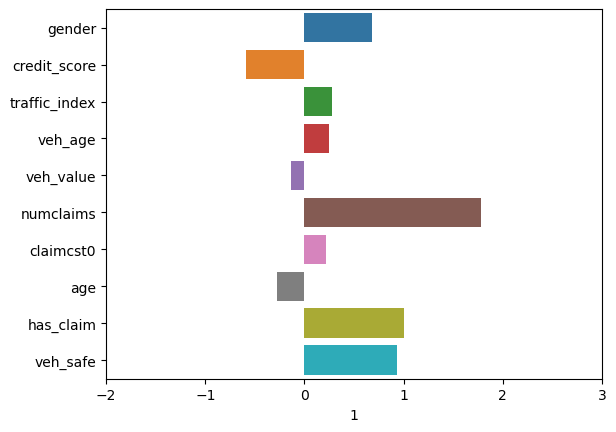

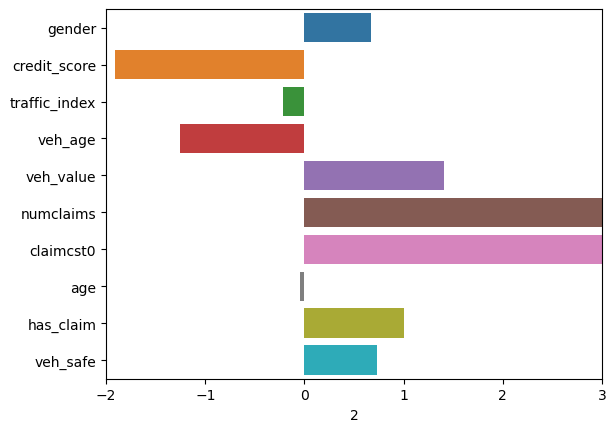

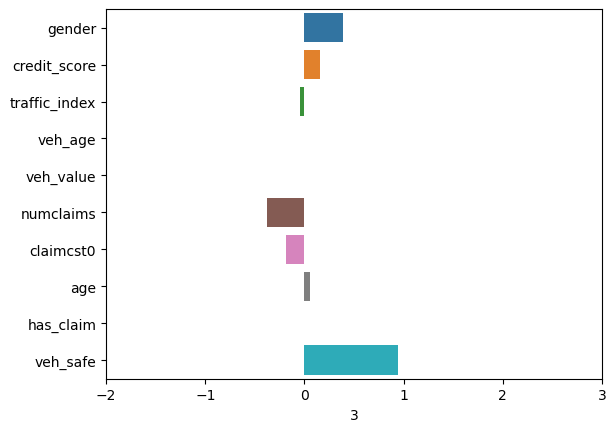

In [117]:
for i in range(0,4):
    sns.barplot(x=cluster_df[i],y=cluster_df.index)
    plt.xlim(-2,3)
    plt.show()

Cluster 0
* credit score is low, traffic env is relatively safe 
* multi claims and claim cost is not high

Cluster 1
* credit score is low, traffic env is relatively safe
* less claims and claim cost is very high

Cluster 2
* credit score is low, traffic env is relatively unsafe
* multi claims and claim cost is low

Cluster 3
* credit score is high, traffic env is safe
* no claim

#### Reduce the dimensionality to visualise the data:

In [118]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
pca_df=pca.fit_transform(po_cluster)

x=pca_df[:,0]
y=pca_df[:,1]

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

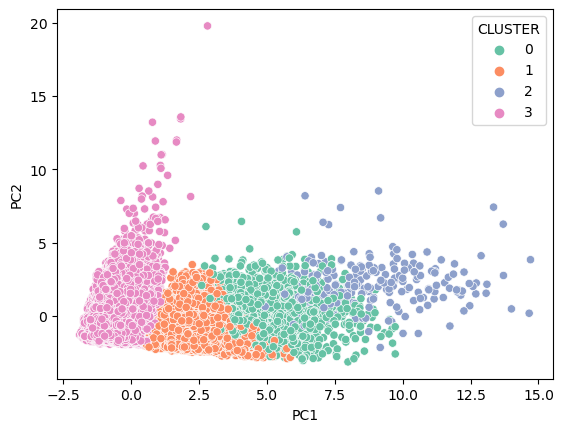

In [119]:
pc=pd.DataFrame({"PC1":x,"PC2":y,"CLUSTER":po_cluster['CLUSTER']})
sns.scatterplot(x=pc["PC1"],y=pc["PC2"],hue=pc["CLUSTER"],palette="Set2")

#### clustering model for quote 2018

In [120]:
qu_cluster=qu_2018.copy()

In [121]:
qu_cluster.drop(['quote_number','date_of_birth','agecat', 'area'],axis=1,inplace=True)
qu_cluster.drop(['prob_noclaim','prob_claim'],axis=1,inplace=True)

In [122]:
qu_cluster

,gender,credit_score,traffic_index,veh_age,veh_body,veh_value,age,has_claim,predicted_avg_claim_cost
0,F,750.0,124.5,2,HBACK,1.100,50,0,0.000000
1,M,567.0,116.0,3,STNWG,2.079,34,1,644.009923
2,M,378.0,111.4,3,HDTOP,2.354,56,1,12198.329533
3,F,807.0,43.5,4,UTE,1.969,45,0,0.000000
4,M,844.0,111.0,1,HBACK,1.969,73,0,0.000000
...,...,...,...,...,...,...,...,...,...
7459,F,690.0,71.4,4,STNWG,1.056,52,0,0.000000
7460,M,558.0,142.5,1,STNWG,4.521,60,1,8519.696474
7461,F,527.0,62.7,1,STNWG,3.102,52,1,6616.330047
7462,M,817.0,129.0,4,SEDAN,0.803,60,0,0.000000


In [123]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
#convert binary
le = LabelEncoder()
for i in ['gender']:
    qu_cluster[i] = le.fit_transform(qu_cluster[i])
#scaling the numerical data
dep=['credit_score', 'traffic_index', 'veh_age', 'veh_value', 'age', 'predicted_avg_claim_cost']
std = StandardScaler()
qu_cluster[dep] = std.fit_transform(qu_cluster[dep])
#
nosafe=['BUS','CONVT','HDTOP','MCARA','MIBUS','RDSTR','TRUCK']
qu_cluster['veh_safe']=1
qu_cluster.loc[qu_cluster['veh_body'].isin(nosafe),'veh_safe']=0
qu_cluster.drop('veh_body',axis=1,inplace=True)

In [124]:
qu_cluster_in=qu_cluster.loc[qu_cluster['has_claim']==1,:]
qu_cluster_in.drop('has_claim',axis=1,inplace=True)

In [125]:
model=KMeans(n_clusters=3)
model.fit(qu_cluster_in)
labels=model.labels_

In [126]:
qu_cluster["CLUSTER"]=3
qu_cluster.loc[qu_cluster['has_claim']==1,"CLUSTER"]=labels
qu_cluster.head()

,gender,credit_score,traffic_index,veh_age,veh_value,age,has_claim,predicted_avg_claim_cost,veh_safe,CLUSTER
0,0,0.655131,0.595163,-0.635461,-0.651040,0.039559,0,-0.340063,1,3
1,1,-0.696825,0.343511,0.305095,0.110066,-1.007351,1,-0.181385,1,1
2,1,-2.093109,0.207322,0.305095,0.323860,0.432151,1,2.665490,0,0
3,0,1.076233,-1.802937,1.245651,0.024548,-0.287600,0,-0.340063,1,3
4,1,1.349579,0.195480,-1.576017,0.024548,1.544493,0,-0.340063,1,3


In [127]:
qu_cluster.to_csv(r'data\external\auto_potential_customers_2018_cluster.csv')